## Load Libary and Dataset

In [1]:
!pip install nltk

In [2]:
# imports the essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from textblob import TextBlob
from sklearn.manifold import TSNE

In [3]:
import re
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from nltk.util import ngrams
from collections import Counter
from collections import Counter, defaultdict


In [4]:
# mounted to google drive, so in no need to upload .csv every time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/CCNY/#2-ML/final project/#1-datasets/fake_real.csv', sep=',', encoding='utf-8', quotechar='"')
df.head()

,Unnamed: 0,Content,Title,Type
0,0,new york reuters us environmental group sierra...,politicsNews,true
1,1,washington reuters us air force asked industry...,politicsNews,true
2,2,saturday paul ryan posted photo instagram phot...,News,fake
3,3,america keeps waiting word hillary indicted ob...,politics,fake
4,4,religion peace ht weasel zippers,left-news,fake


## Data Preprocessing


In [6]:
df.shape

(44898, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  44898 non-null  int64 
 1   Content     44266 non-null  object
 2   Title       44898 non-null  object
 3   Type        44898 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [8]:
# Only 'Content' has null value, check how these null look like
df.loc[df['Content'].isna()].head()

,Unnamed: 0,Content,Title,Type
77,77,NaN,politics,fake
88,88,NaN,politics,fake
275,275,NaN,left-news,fake
346,346,NaN,politics,fake
530,530,NaN,left-news,fake


In [9]:
# Check unique value of 'Title'
df['Title'].value_counts()

Title
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

In [10]:
# For our task to detect fake news, we will take 'Type' as the target variable. Check unique value for 'Type'
df['Type'].value_counts()

Type
fake    23481
true    21417
Name: count, dtype: int64

### Drop null value

For our task, we will need to work on text, so the text analysis is crucial. Unlike numeric variable, we can not impute the missing value here. And luckily, the missing row takes only 1.4% of the total row counts, so dropping null values is a feasible option.

In [11]:
# Remove rows with missing values
df.dropna(axis = 0, inplace = True)

In [12]:
df.shape

(44266, 4)

### Drop unnecessary features

In [13]:
# Drop 'Unamed', as it is dup with row index
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [14]:
df.head()

,Content,Title,Type
0,new york reuters us environmental group sierra...,politicsNews,true
1,washington reuters us air force asked industry...,politicsNews,true
2,saturday paul ryan posted photo instagram phot...,News,fake
3,america keeps waiting word hillary indicted ob...,politics,fake
4,religion peace ht weasel zippers,left-news,fake


Before going forward, we would like to find out if 'Title' and 'Type' are heavily correlated, say a certain type of 'Title' is almost True or Flase. If so, the dataset itself has a flaw, because we can simply deduce the true or fake by 'Title'.

In [15]:
# Create the pivot table
pivot_table = df.pivot_table(index='Title', columns='Type', aggfunc='size', fill_value=0)

# Display the pivot table
print(pivot_table)

Type             fake   true
Title                       
Government News  1498      0
Middle-east       778      0
News             9050      0
US_News           783      0
left-news        4309      0
politics         6432      0
politicsNews        0  11271
worldnews           0  10145


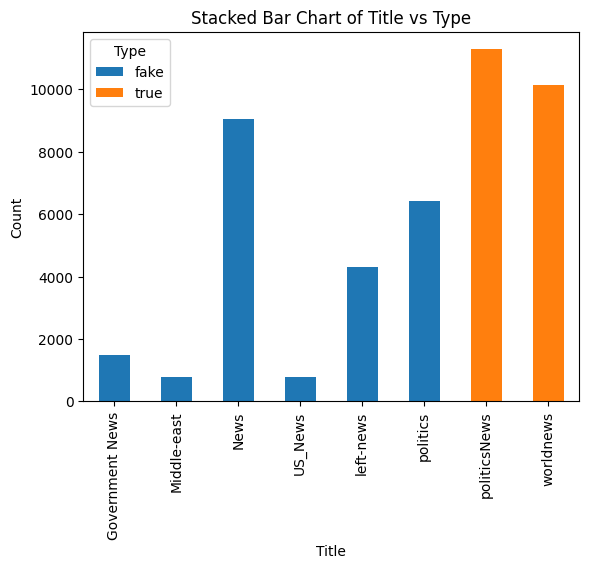

In [16]:
# Group by 'Title' and 'Type', then count rows for each subgroup
grouped = df.groupby(['Title', 'Type']).size().unstack(fill_value=0)

# Plotting
grouped.plot(kind='bar', stacked=True)

# Customize the plot
plt.title('Stacked Bar Chart of Title vs Type')
plt.xlabel('Title')
plt.ylabel('Count')
plt.legend(title='Type')

# Show the plot
plt.show()

In [17]:
# Since 'Title' is +/- 100% correlated with 'Type', it has to be removed.
df.drop(columns = ['Title'], inplace = True)

### Encode categorical variable

In [18]:
# map to numeric labels
df['Label'] = df['Type'].map({'fake': 0, 'true': 1}).astype(int)

In [19]:
df.head()

,Content,Type,Label
0,new york reuters us environmental group sierra...,true,1
1,washington reuters us air force asked industry...,true,1
2,saturday paul ryan posted photo instagram phot...,fake,0
3,america keeps waiting word hillary indicted ob...,fake,0
4,religion peace ht weasel zippers,fake,0


In [20]:
df.drop(columns = ['Type'], inplace = True)

## Text Processing



### Raw Text Cleaning

Now we perform processing of the raw text, such as removing the fillers, special characters, proofreading the misspelling words, etc.

In [21]:
# convert Content column to string
df['Content'] = df['Content'].astype(str)

In [22]:
# Function to remove HTML tags from text
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text(separator=" ")
    return cleaned_text

# Apply the function to remove HTML tags from the 'Content' column
df['Content'] = df['Content'].apply(remove_html_tags)

In [23]:
# Function to remove punctuation marks from text
def remove_punctuation(text):
    # Define the regex pattern to match punctuation marks
    punctuation_pattern = r'[^\w\s]'
    # Replace punctuation marks with empty string
    cleaned_text = re.sub(punctuation_pattern, '', text)
    return cleaned_text

# Apply the function to remove punctuation from the 'Content' column
df['Content'] = df['Content'].apply(remove_punctuation)

In [24]:
# Function to remove special characters and numbers from text
def remove_special_characters_and_numbers(text):
    # Define the regex pattern to match special characters and numbers
    special_characters_and_numbers_pattern = r'[^a-zA-Z\s]'
    # Replace special characters and numbers with empty string
    cleaned_text = re.sub(special_characters_and_numbers_pattern, '', text)
    return cleaned_text

# Apply the function to remove special characters and numbers from the 'Content' column
df['Content'] = df['Content'].apply(remove_special_characters_and_numbers)

In [25]:
# Function to convert text to lowercase
def convert_to_lowercase(text):
    return text.lower()

# Apply the function to convert text to lowercase for the 'Content' column
df['Content'] = df['Content'].apply(convert_to_lowercase)

### Text Processing with NLTK

Typically, there are multiple steps to take here, such as tokenization, removing stopwords, stemming, etc. However, it varies to different datasets. So, it's wise to further explore before taking regular process.

In [26]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [27]:
# Function to tokenize the text
def tokenize_text(text):
    return word_tokenize(text)

# Apply the function to tokenize the 'Content' column
df['Tokens'] = df['Content'].apply(tokenize_text)


In [28]:
# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from tokens
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

# Apply the function to remove stopwords from the 'Tokens' column
df['Tokens'] = df['Tokens'].apply(remove_stopwords)

In [29]:
# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Apply the function to lemmatize the 'Tokens' column
df['Tokens'] = df['Tokens'].apply(lemmatize_tokens)

In [30]:
# Function to join tokens back into a single string
def join_tokens(tokens):
    return ' '.join(tokens)

# Apply the function to join the processed tokens in the 'Tokens' column
df['Processed_Content'] = df['Tokens'].apply(join_tokens)

# Reorder columns
df = df[['Content', 'Tokens', 'Processed_Content', 'Label']]

In [31]:
df.head()

,Content,Tokens,Processed_Content,Label
0,new york reuters us environmental group sierra...,"[new, york, reuters, u, environmental, group, ...",new york reuters u environmental group sierra ...,1
1,washington reuters us air force asked industry...,"[washington, reuters, u, air, force, asked, in...",washington reuters u air force asked industry ...,1
2,saturday paul ryan posted photo instagram phot...,"[saturday, paul, ryan, posted, photo, instagra...",saturday paul ryan posted photo instagram phot...,0
3,america keeps waiting word hillary indicted ob...,"[america, keep, waiting, word, hillary, indict...",america keep waiting word hillary indicted oba...,0
4,religion peace ht weasel zippers,"[religion, peace, ht, weasel, zipper]",religion peace ht weasel zipper,0


## Text Exploratory

### Token Counts

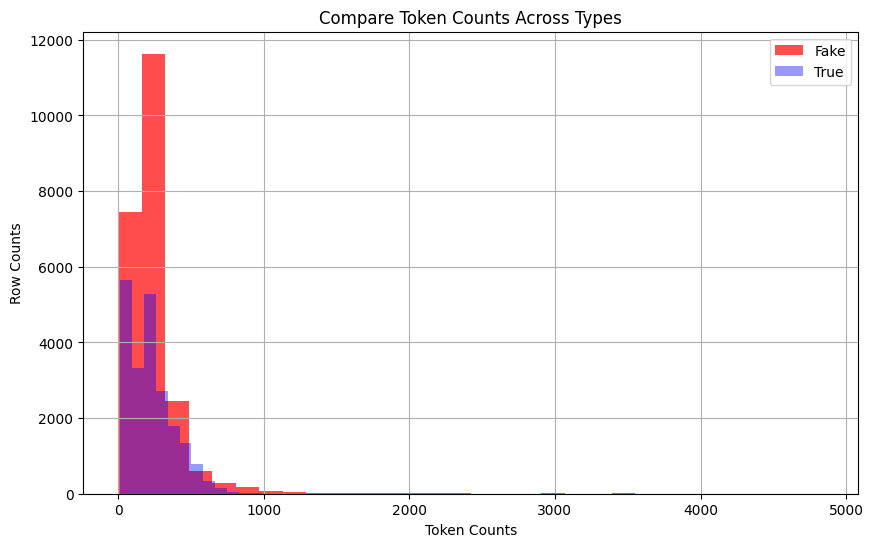

In [38]:
# Filter data for two types
fake_news = df[df['Label'] == 0]
true_news = df[df['Label'] == 1]

# Plot histogram for text lengths for each type
plt.figure(figsize=(10, 6))

# Plot histogram for type 1
plt.hist(fake_news['Tokens'].apply(len), bins=30, color='red', alpha=0.7, label='Fake')

# Plot histogram for type 2
plt.hist(true_news['Tokens'].apply(len), bins=30, color='blue', alpha=0.4, label='True')

plt.title('Compare Token Counts Across Types')
plt.xlabel('Token Counts')
plt.ylabel('Row Counts')
plt.legend()
plt.grid(True)
plt.show()

### Term Frequency

In [39]:
# Initialize an empty defaultdict to store word frequencies for each type
word_freq_by_type = defaultdict(lambda: defaultdict(int))

# Initialize variables to store vocabulary size and rare word count for each type
vocabulary_size_by_type = defaultdict(int)
num_rare_words_by_type = defaultdict(int)

# Set the batch size for updating word frequencies
batch_size = 1000  # Adjust as needed

# Iterate over each document to update word frequencies incrementally
for i, (tokens, type) in enumerate(zip(df['Tokens'], df['Label']), start=1):
    for token in tokens:
        word_freq_by_type[type][token] += 1  # Update word frequencies for each type

    # Update vocabulary size and count rare words after processing a batch of documents
    if i % batch_size == 0 or i == len(df):
        for t in word_freq_by_type.keys():
            vocabulary_size_by_type[t] = len(word_freq_by_type[t])
            num_rare_words_by_type[t] = sum(1 for freq in word_freq_by_type[t].values() if freq == 1)

# Output vocabulary statistics and plot the distribution of rare words versus common words for each type
for t in vocabulary_size_by_type.keys():
    print("\nType:", t)
    print("Size of Vocabulary:", vocabulary_size_by_type[t])
    print("Number of Rare Words (frequency = 1):", num_rare_words_by_type[t])

    # Plot the distribution of rare words versus common words for each type
    labels = ['Common Words (Frequency > 1)', 'Rare Words (Frequency = 1)']
    sizes = [vocabulary_size_by_type[t] - num_rare_words_by_type[t], num_rare_words_by_type[t]]



Type: 1
Size of Vocabulary: 71250
Number of Rare Words (frequency = 1): 26237

Type: 0
Size of Vocabulary: 168535
Number of Rare Words (frequency = 1): 75718


**Visualize with WordCloud**

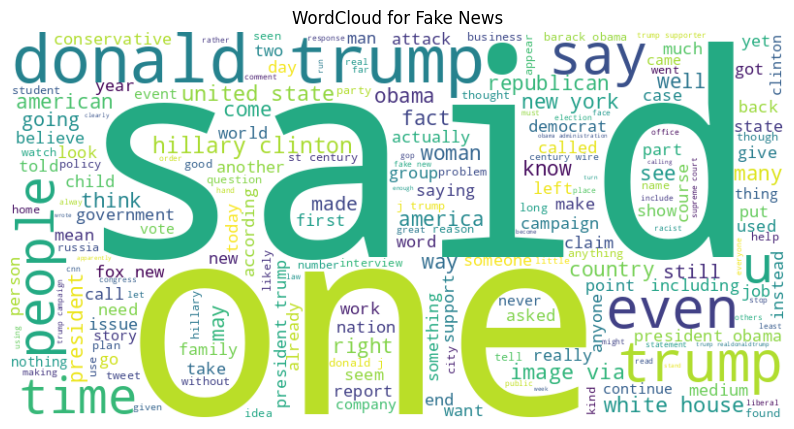

In [47]:
# Filter fake news
fake_news_flatten = ' '.join(df[df['Label'] == 0]['Processed_Content'])

# Generate WordCloud for fake news
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_news_flatten)

# Plot WordCloud for fake news
plt.figure(figsize=(10, 6))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title('WordCloud for Fake News')
plt.axis('off')
plt.show()

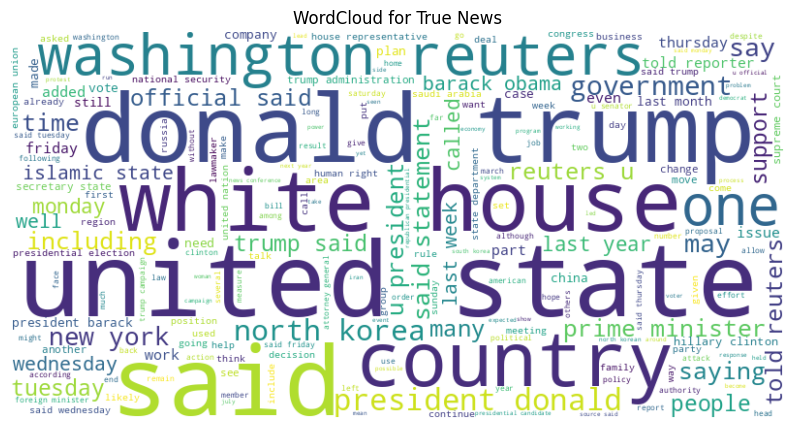

In [46]:
# Filter true news
true_news_flatten = ' '.join(df[df['Label'] == 1]['Processed_Content'])

# Generate WordCloud for true news
true_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(true_news_flatten)

# Plot WordCloud for true news
plt.figure(figsize=(10, 6))
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.title('WordCloud for True News')
plt.axis('off')
plt.show()

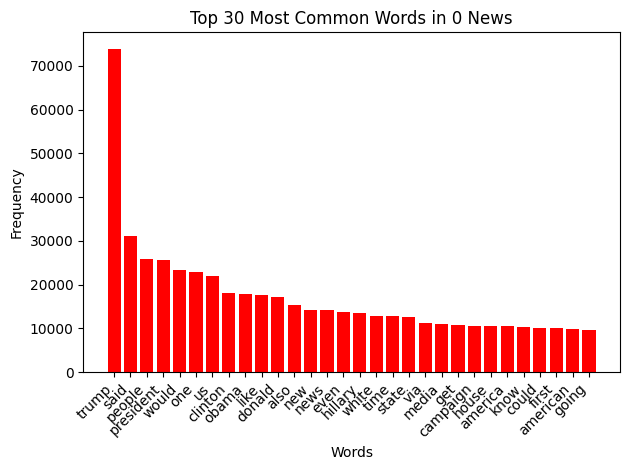

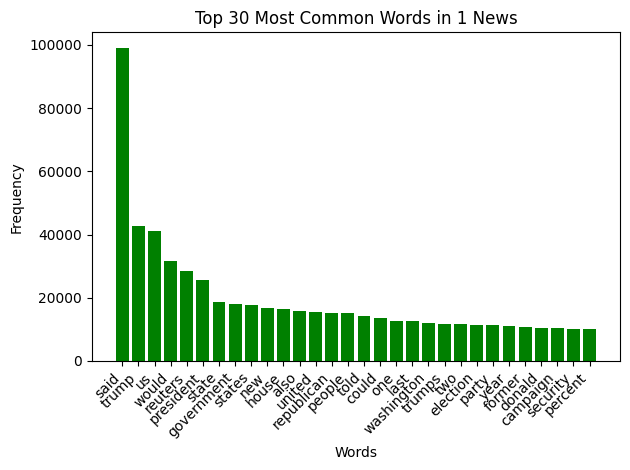

In [48]:
# Define a function to calculate word frequency and plot the bar chart
def plot_word_frequency(df, type, top_n=10):
    # Filter data by type
    filtered_data = df[df['Label'] == type]

    # Join all the content for the specified type
    text = ' '.join(filtered_data['Content'])

    # Tokenize the text
    tokens = text.split()

    # Calculate word frequency
    word_freq = Counter(tokens)

    # Get the top N most common words
    top_words = dict(word_freq.most_common(top_n))

    # Plot bar chart
    colors = ['red' if type == 0 else 'green'] * top_n
    plt.bar(top_words.keys(), top_words.values(), color=colors)
    plt.title(f'Top {top_n} Most Common Words in {type} News')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Specify the types for which you want to plot word frequency
types = [0, 1]

# Plot word frequency for each type
for type in types:
    plot_word_frequency(df, type, top_n=30)

### Co-occurrency

In [50]:
# Initialize CountVectorizer to create co-occurrence matrix for fake news
fake_vec = CountVectorizer(ngram_range=(1, 2), max_features=1000)
fake_matrix = fake_vec.fit_transform(fake_news['Processed_Content'])
fake_feature = fake_vec.get_feature_names_out()

# Initialize CountVectorizer to create co-occurrence matrix for true news
true_vec = CountVectorizer(ngram_range=(1, 2), max_features=1000)
true_matrix = true_vec.fit_transform(true_news['Processed_Content'])
true_feature = true_vec.get_feature_names_out()


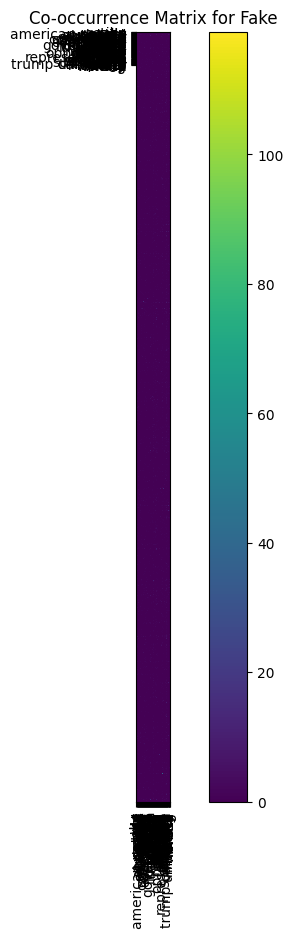

In [51]:
# Visualize co-occurrence matrix for fake news
plt.figure(figsize=(10, 10))
plt.imshow(fake_matrix.toarray(), cmap='viridis', interpolation='nearest')
plt.title('Co-occurrence Matrix for Fake')
plt.colorbar()
subset_feature_names_type1 = fake_feature[::10]  # Select every 10th feature name
plt.xticks(ticks=range(0, len(fake_feature), 10), labels=subset_feature_names_type1, rotation=90)
plt.yticks(ticks=range(0, len(fake_feature), 10), labels=subset_feature_names_type1)
plt.show()


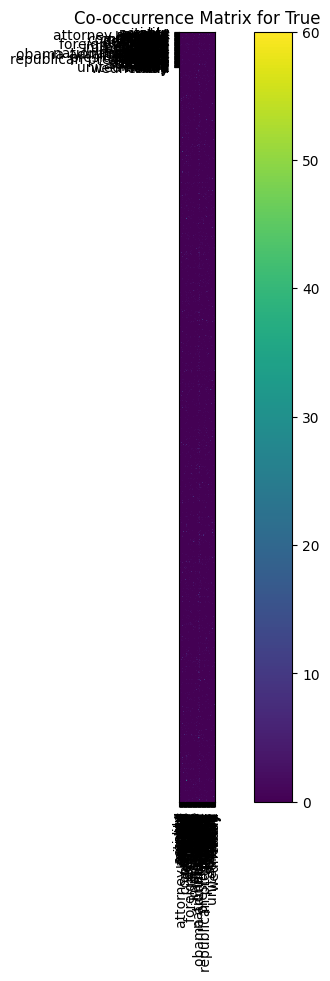

In [52]:
# Visualize co-occurrence matrix for true news
plt.figure(figsize=(10, 10))
plt.imshow(true_matrix.toarray(), cmap='viridis', interpolation='nearest')
plt.title('Co-occurrence Matrix for True')
plt.colorbar()
subset_feature_names_type2 = true_feature[::10]  # Select every 10th feature name
plt.xticks(ticks=range(0, len(true_feature), 10), labels=subset_feature_names_type2, rotation=90)
plt.yticks(ticks=range(0, len(true_feature), 10), labels=subset_feature_names_type2)
plt.show()


### N-gram Analysis

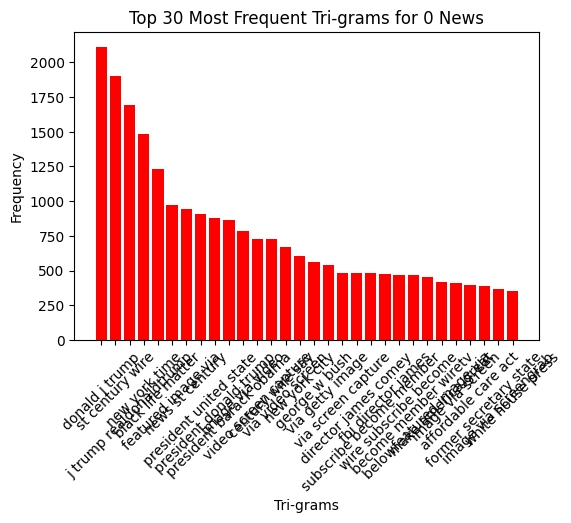

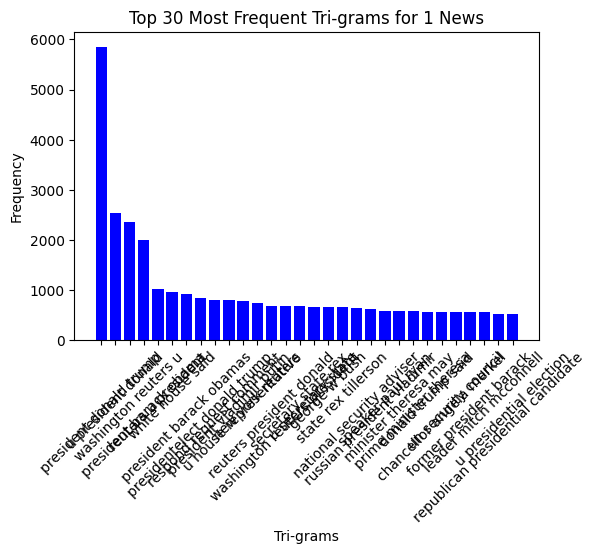

In [55]:
# Function to generate n-grams
def generate_ngrams(tokens, n):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

# Function to analyze n-gram frequency for a specific type
def analyze_ngram_frequency(data, n):
    ngram_freq = Counter()
    for tokens in data:
        ngrams_list = generate_ngrams(tokens, n)
        ngram_freq.update(ngrams_list)
    return ngram_freq

# Specify the types for which you want to analyze n-gram frequency
types = [0, 1]

# Plot top N most common tri-grams for each type with different colors
colors = ['red', 'blue']

for i, type in enumerate(types):
    # Filter data by type
    filtered_data = df[df['Label'] == type]

    # Analyze tri-gram frequency for the filtered data
    trigram_freq = analyze_ngram_frequency(filtered_data['Tokens'], 3)

    # Get top N most common tri-grams
    top_n_trigrams = trigram_freq.most_common(30)

    # Plot bar chart for top N most common tri-grams with different colors
    plt.figure(figsize=(6, 4))
    plt.bar([' '.join(ngram[0]) for ngram in top_n_trigrams], [ngram[1] for ngram in top_n_trigrams], color=colors[i])
    plt.title(f'Top 30 Most Frequent Tri-grams for {type} News')
    plt.xlabel('Tri-grams')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

### Sentiment Analysis

In [57]:
# Function to calculate sentiment score using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to each document
df['Sentiment'] = df['Processed_Content'].apply(get_sentiment)

df['Sentiment'].head()

0    0.080455
1    0.057019
2    0.039107
3    0.061415
4    0.000000
Name: Sentiment, dtype: float64

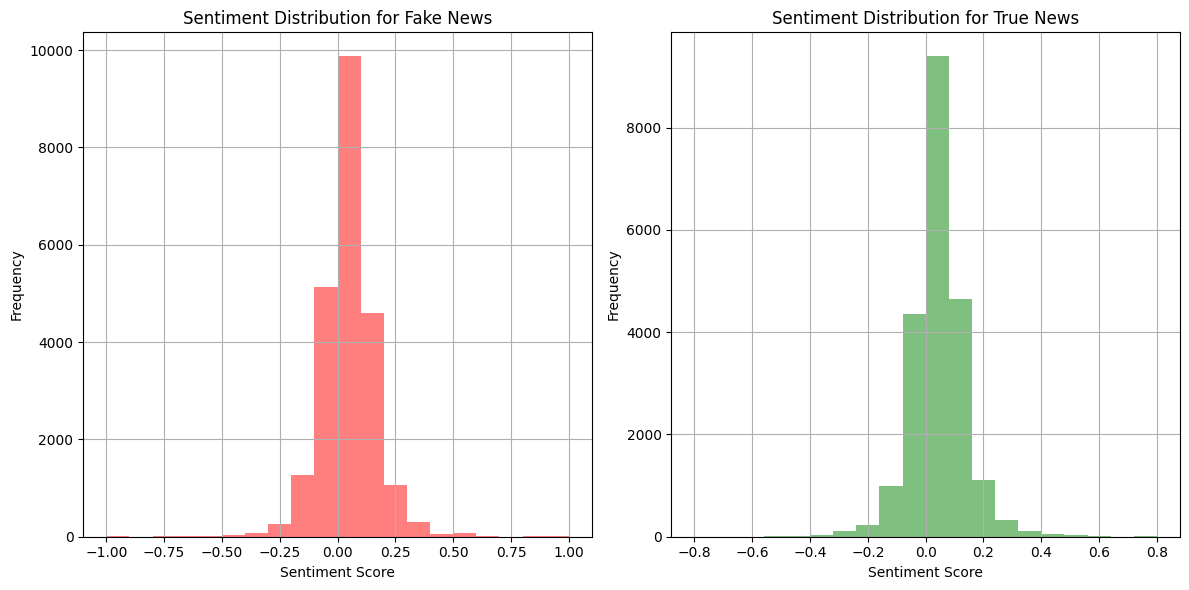

In [58]:
# Create subplots for each type
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot sentiment scores for fake
axes[0].hist(df[df['Label'] == 0]['Sentiment'], bins=20, color='red', alpha=0.5)
axes[0].set_title('Sentiment Distribution for Fake News')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot sentiment scores for true
axes[1].hist(df[df['Label'] == 1]['Sentiment'], bins=20, color='green', alpha=0.5)
axes[1].set_title('Sentiment Distribution for True News')
axes[1].set_xlabel('Sentiment Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Feature Extraction

### Count Vectors

In [76]:
    X = df['Processed_Content']

    # Initialize CountVectorizer to create BoW features
    vectorizer = CountVectorizer()

    # Fit and transform the text data to generate BoW features
    X_bow = vectorizer.fit_transform(X)

    # Print the shape of the BoW matrix
    print("Shape of BoW matrix:", X_bow.shape)

    # Print feature names
    print("Feature names:", vectorizer.get_feature_names_out())


Shape of BoW matrix: (44266, 203312)
Feature names: ['aa' 'aaa' 'aaaaackkk' ... 'zzzzaaaacccchhh' 'zzzzzzzz' 'zzzzzzzzzzzzz']


### TF-IDF

In [78]:
X = df['Processed_Content']

# Initialize TfidfVectorizer to create TF-IDF features
vectorizer = TfidfVectorizer()

# Fit and transform the text data to generate TF-IDF features
X_tfidf = vectorizer.fit_transform(X)

# Print the shape of the TF-IDF matrix
print("Shape of TF-IDF matrix:", X_tfidf.shape)

# Print feature names
print("Feature names:", vectorizer.get_feature_names_out())


Shape of TF-IDF matrix: (44266, 203312)
Feature names: ['aa' 'aaa' 'aaaaackkk' ... 'zzzzaaaacccchhh' 'zzzzzzzz' 'zzzzzzzzzzzzz']
